# Homework 4


## AISHWARYA GIRDHAR

Aishwarya.Girdhar@student.uibk.ac.at 

Aish0107

30.10.2018.

### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall Week-5-Thu lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- You can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models.
- You can use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can do approximate model comparison based on the BIC 

In [20]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

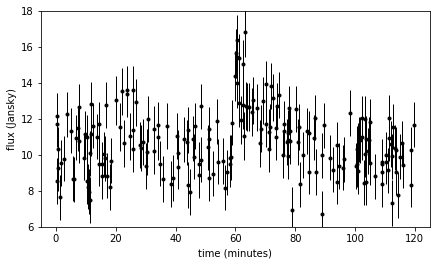

In [21]:
# read data
data = np.loadtxt('data/HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

# t = time(minutes)
#y_obs = flux(Jansky)
#sigma_y = y_err
# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

### Single Burst Model

@pickle_results: using precomputed results from 'matchedfilt_burst.pkl'


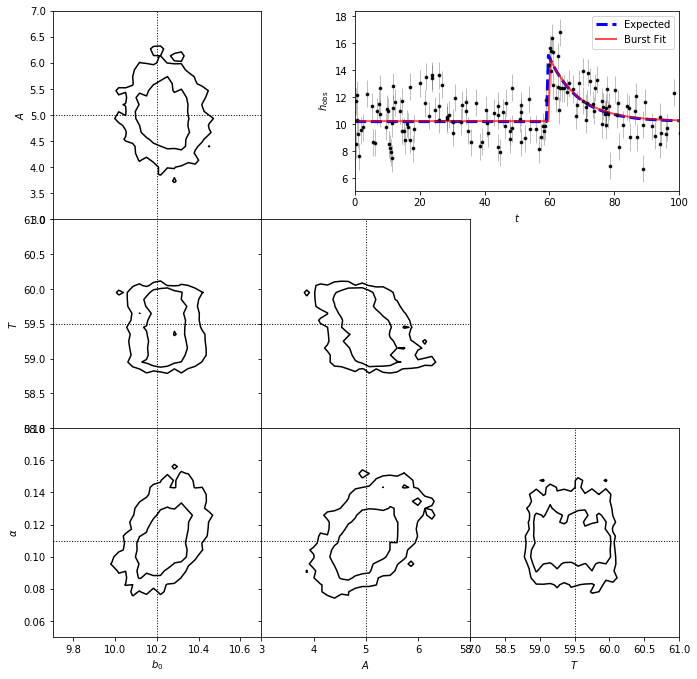

Values for b0, A, alpha, T are: (array(10.230118483588837), array(4.702265582181431), 0.10889034797978593, array(60.012917470201494))


In [23]:
#----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)     #creates an array of size t.shape with random elements
    y.fill(b0)                #fills the array y with the value b0 for all elements
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y


np.random.seed(0)

N = 200
b0_true = 10.2
A_true = 5         #Amplitude of burst
alpha_true = 0.11   #exponential decay constant
T_true = 59.5      #Time of burst
sigma = 1.0

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.7, 10.7), (3, 7), (58, 61), (0.05, 0.18)]
true = [b0_true, A_true, T_true, alpha_true]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 200)
y_fit = burst(t_fit, *fit_vals)
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=0.5, c='k', alpha=0.5)
ax.plot(t_fit, y_true, '--', c='blue', lw = 3, label = 'Expected')
ax.plot(t_fit, y_fit, '-k', c='red', lw =  2, alpha=0.7, label = 'Burst Fit')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')
ax.legend()

plt.show() 
print ("Values for b0, A, alpha, T are:", fit_vals)

### Single Peak: Using Gaussian Model

 [-----------------100%-----------------] 25000 of 25000 complete in 12.5 sec

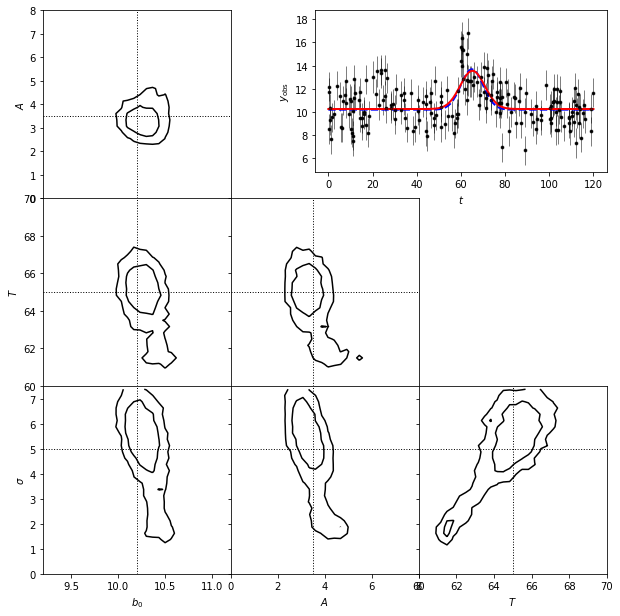

In [24]:
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

np.random.seed(42)
N = 101
b0_true = 10.2
A_true = 3.5
sigma_true = 5.0
T_true = 65
#err0_y = 0.5
err_y = sigma_y
#t = 100 * np.random.random(N)
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
#err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
#y_obs = np.random.normal(y_true, err_y)

labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']
limits = [(9.2, 11.2), (0, 8), (60, 70), (0.0, 7.5)]
true = [b0_true, A_true, T_true, sigma_true]

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


# uniform prior on log(alpha)
@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, sigma=sigma, T=T):
    return GaussAndBkgd(t, b0, A, sigma, T)

y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_gauss.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')


# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 101)
y_fit = GaussAndBkgd(t_fit, *fit_vals)
y_true = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, err_y, fmt='.', lw=1, c='k', alpha=0.5)
ax.plot(t_fit, y_true, '--', c='blue', lw=2)
ax.plot(t_fit, y_fit, '-k', c='red',lw=2)
#ax.set_xlim(-10, 110)
#ax.set_ylim(8.5, 16.5)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show() 

### Double Burst Model : GMM

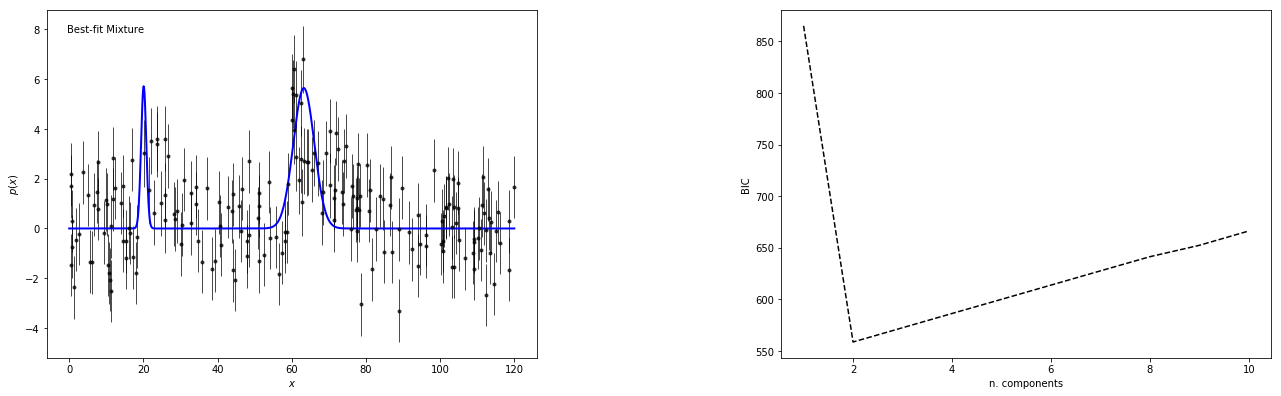

In [25]:
# Modeled after astroML book figure 4.2  
import warnings
warnings.filterwarnings('ignore')
from sklearn.mixture import GMM

def doGMM(Ndata, noiseStd=0.00000001):
    #------------------------------------------------------------

    np.random.seed(1)
    gmm = GMM(2, n_iter=1)
    gmm.means_ = np.array([[20], [63]])
    gmm.covars_ = np.array([[1], [3]]) ** 2
    gmm.weights_ = np.array([0.15,0.85])

    X = gmm.sample(Ndata)
    #------------------------------------------------------------

    # fit models with 1-10 components
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]
    
    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)

    # compute the BIC
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------

    fig = plt.figure(figsize=(20, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(0, 120, 1000)
    logprob, responsibilities = M_best.score_samples(x.reshape((-1,1))) ## fix
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

   
    ax.errorbar(t, y_obs-10.0, sigma_y, fmt='.', lw=1, c='k', alpha=0.7)
    ax.plot(x, 50*pdf ,'-b', lw=2)
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')


    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    plt.show()
    
doGMM(100)    

### BIC Conclusion

The right panel shows that the 2-component model has a much lower BIC. This is hence sufficient evidence to claim that the double burst model is really really better choice than the single burst model.

### Double Burst Model

In [26]:
def doubleburst(t,y_obs,sigma_y,b0=None):
    def burst(t, b0, A, alpha, T):
        """Burst model"""
        y = np.empty(t.shape)     #creates an array of size t.shape with random elements
        y.fill(b0)                #fills the array y with the value b0 for all elements
        mask = (t >= T)
        y[mask] += A * np.exp(-alpha * (t[mask] - T))
        return y


    np.random.seed(0)
    N = len(t) 
    sigma=1.0


    #----------------------------------------------------------------------
    # Set up MCMC sampling
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
    log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


    # uniform prior on log(alpha)
    @pymc.deterministic
    def alpha(log_alpha=log_alpha):
        return np.exp(log_alpha)


    @pymc.deterministic
    def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
        return burst(t, b0, A, alpha, T)

    y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

    model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
                 alpha=alpha, y_model=y_model, y=y)


    #----------------------------------------------------------------------
    # Run the MCMC sampling
#     @pickle_results('matchedfilt_burst.pkl')
    def compute_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

        M = pymc.MAP(model)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

        return traces, fit_vals

    traces, fit_vals = compute_MCMC_results()

    t_fit=t
    y_fit = burst(t_fit, *fit_vals)
    print(*fit_vals)
    return y_fit,t_fit,(*fit_vals)

In [27]:
set1=(t<=50)
t1 = t[set1]
burst1,tfit1,b01,A1,alpha1,T1=doubleburst(t1,y_obs[set1],sigma_y[set1])
set2=(t>0)
t2 = t[set2]
burst2,tfit2,b02,A2,alpha2,T2=doubleburst(t2,y_obs[set2],sigma_y[set2])

 [-----------------100%-----------------] 25000 of 25000 complete in 9.1 sec10.090543966034911 3.318701404813866 0.154306696473 20.129905193252025
 [-----------------100%-----------------] 25000 of 25000 complete in 11.4 sec10.235162013947892 4.92780504057783 0.108940612929 59.55856215985654


Single Burst Model, BIC:  261.745141948
Double Burst Model, BIC:  235.215611516


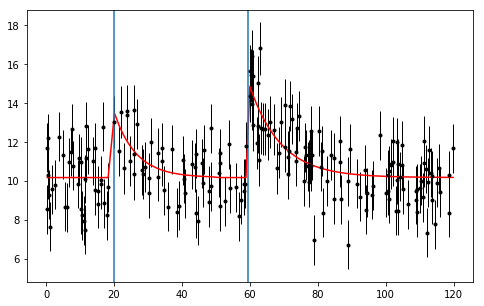

In [35]:
chi2_1=np.sum(((y_obs[set2]-burst2)/sigma_y[set2])**2)
bic_1=chi2_1+4*np.log(len(burst2))
print("Single Burst Model, BIC: ", bic_1)

burst=np.concatenate((burst1-b01,burst2[(tfit2>50)]-b02))+(b01+b02)/2.
t_fit=np.concatenate((tfit1,tfit2[tfit2>50]))
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot()
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, burst, '-k', c='red')
plt.axvline(x=T1)
plt.axvline(x=T2)

chi2_2=np.sum(((y_obs-burst)/sigma_y)**2)
bic_2=chi2+4*np.log(len(burst))
print("Double Burst Model, BIC: ", bic_2)